# Edge-IIoTset Cyber Security Dataset of IoT & IIoT

[Kaggle Reference](https://www.kaggle.com/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/)

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

## Load Dataset

In [2]:
dataset_path = kagglehub.dataset_download(
    "mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot"
)
dataset_path

'C:\\Users\\Sesugh\\.cache\\kagglehub\\datasets\\mohamedamineferrag\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\versions\\5'

In [3]:
df_main = pl.read_csv(
    f"{dataset_path}/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv",
    infer_schema_length=1000,
    schema_overrides={
        "dns.qry.name.len": pl.Utf8,
        "tcp.srcport": pl.Utf8,
        "http.request.method": pl.Utf8,
        "http.request.full_uri": pl.Utf8,
        "http.request.version": pl.Utf8,
        "http.request.uri.query": pl.Utf8,
        "http.file_data": pl.Utf8,
        "http.referer": pl.Utf8,
    },
)
df_main.head()

frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.file_data,http.content_length,http.request.uri.query,http.request.method,http.referer,http.request.full_uri,http.request.version,http.response,http.tls_port,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.fin,tcp.connection.rst,tcp.connection.syn,tcp.connection.synack,tcp.dstport,tcp.flags,tcp.flags.ack,tcp.len,tcp.options,tcp.payload,tcp.seq,tcp.srcport,udp.port,udp.stream,udp.time_delta,dns.qry.name,dns.qry.name.len,dns.qry.qu,dns.qry.type,dns.retransmission,dns.retransmit_request,dns.retransmit_request_in,mqtt.conack.flags,mqtt.conflag.cleansess,mqtt.conflags,mqtt.hdrflags,mqtt.len,mqtt.msg_decoded_as,mqtt.msg,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
str,str,str,str,f64,f64,str,f64,f64,f64,f64,str,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,i64,str
""" 2021 11:44:10.081753000 ""","""192.168.0.128""","""192.168.0.101""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,"""0.0""",0.0,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""",0.0,0.0,1.0,3.1533e9,47892.0,0.0,0.0,0.0,1.0,64855.0,18.0,1.0,0.0,"""020405b40101040201030307""","""0""",0.0,"""1883.0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0,"""Normal"""
""" 2021 11:44:10.162218000 ""","""192.168.0.101""","""192.168.0.128""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,"""0.0""",0.0,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""",0.0,0.0,1.0,3.44794516e8,16077.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,14.0,"""0""","""100c00044d5154540402003c0000""",1.0,"""64855.0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",1.0,2.0,16.0,12.0,0.0,"""0""",1.0,4.0,"""MQTT""","""0""",0.0,4.0,0.0,0.0,0.0,0,"""Normal"""
""" 2021 11:44:10.162271000 ""","""192.168.0.128""","""192.168.0.101""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,"""0.0""",0.0,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""",0.0,0.0,15.0,3.1533e9,62675.0,0.0,0.0,0.0,0.0,64855.0,16.0,1.0,0.0,"""0""","""0""",1.0,"""1883.0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0,"""Normal"""
""" 2021 11:44:10.162641000 ""","""192.168.0.128""","""192.168.0.101""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,"""0.0""",0.0,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""",0.0,0.0,15.0,3.1533e9,54469.0,0.0,0.0,0.0,0.0,64855.0,24.0,1.0,4.0,"""0""","""20020000""",1.0,"""1883.0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0x00000000""",0.0,0.0,32.0,2.0,0.0,"""0""",2.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0,"""Normal"""
""" 2021 11:44:10.166132000 ""","""192.168.0.101""","""192.168.0.128""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,"""0.0""",0.0,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""",0.0,0.0,5.0,3.4479452e8,53812.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,41.0,"""0""","""3027001854656d7065726174757265…",15.0,"""64855.0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,48.0,39.0,0.0,"""32342e36382037362e34320d0a""",3.0,0.0,"""0""","""Temperature_and_Humidity""",24.0,0.0,0.0,0.0,0.0,0,"""Normal"""


## Data Analysis & Cleaning

Here, we wanna see for every column, what the data looks like? What is the data type? (float?, string?) Are any columns redundant? Meaning they have the same data for all rows? How many unique items do we have for each column?

In [4]:
def summarize_columns(df: pl.DataFrame, features: list | None = None) -> pl.DataFrame:
    """
    For a given Polars DataFrame, analyzes variable types, missing values, and distribution.

    Parameters:
    ----------
    df: pl.DataFrame
    features: list of column names to analyze. If empty, all columns will be considered.

    Returns:
    -------
    pl.DataFrame with structure analysis and recommendations for each feature.
    """

    # Use all columns if features not specified
    features = features or df.columns

    # Helper function to get value densities
    def value_densities(dataframe: pl.DataFrame, col):
        vc = dataframe[col].value_counts(sort=True)
        vc = vc.with_columns((pl.col("count") / pl.col("count").sum()).alias("density"))
        vc = vc.with_columns((pl.col("density") * 100).round(3).alias("density"))
        return vc["density"].to_list()

    # Collect column-wise stats
    result_data = []

    for col in features:
        series = df[col]
        dtype = series.dtype

        total = df.height
        missing = df.select(pl.col(col).is_null().sum())[0, 0]
        observed = total - missing
        missing_rate = round((missing / total) * 100, 2) if total > 0 else 0.0

        nunique = df.select(pl.col(col).n_unique())[0, 0]

        # Distribution densities
        densities = value_densities(df, col)
        first_density = densities[0]
        second_density = densities[1] if len(densities) > 1 else 0.0
        diff_density = round(first_density - second_density, 3)

        # Determine feature type
        if nunique <= 1:
            feature_type = "Superfluous"
        elif nunique == 2:
            feature_type = "Flag"
        elif 2 < nunique <= 10:
            feature_type = "Categorical"
        else:
            feature_type = "Categorical - High Cardinality"

        result_data.append(
            {
                "Feature": col,
                "Observations": observed,
                "Missing": missing,
                "Missing rate (%)": missing_rate,
                "1st value density (%)": first_density,
                "1st to 2nd value density difference (%)": diff_density,
                "Variable type": str(dtype),
                "Unique values": nunique,
                "Feature type": feature_type,
            }
        )

    # Create Polars DataFrame and sort it
    result_df = pl.DataFrame(result_data)
    result_df = result_df.sort(["Feature type", "Unique values"])

    return result_df


def plot_target_relationship(
    df: pl.DataFrame, feature_col: str, target_col: str = "target", log_scale: bool = False
):
    """
    Plot the relationship between a feature column and the target column using Polars for processing.

    Parameters:
        df (pl.DataFrame): The Polars DataFrame
        feature_col (str): Feature column name
        target_col (str): Target column name (categorical)
    """
    # Determine column type
    is_categorical = (
        df[feature_col].dtype in [pl.Utf8, pl.Categorical] or df[feature_col].n_unique() < 20
    )

    if is_categorical:
        # Group by feature and target to count occurrences
        grouped = df.group_by([feature_col, target_col]).len().rename({"len": "count"}).to_pandas()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=grouped, x=feature_col, y="count", hue=target_col)
        if log_scale:
            plt.yscale("log")
        plt.title(f"Distribution of {feature_col} by {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()

    else:
        # Convert needed columns to pandas for seaborn boxplot
        plot_df = df.select([feature_col, target_col]).to_pandas()

        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(data=plot_df, x=target_col, y=feature_col)
        if log_scale:
            ax.set_yscale("log")
        plt.title(f"{feature_col} distribution by {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

In [5]:
columns_df = summarize_columns(df_main)
columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""
"""arp.opcode""",2219201,0,0.0,99.736,99.541,"""Float64""",3,"""Categorical"""
"""mqtt.protoname""",2219201,0,0.0,69.061,41.864,"""String""",3,"""Categorical"""
"""mqtt.len""",2219201,0,0.0,88.777,85.035,"""Float64""",4,"""Categorical"""
"""dns.retransmission""",2219201,0,0.0,99.917,99.875,"""Float64""",4,"""Categorical"""
…,…,…,…,…,…,…,…,…
"""Attack_label""",2219201,0,0.0,72.803,45.606,"""Int64""",2,"""Flag"""
"""mqtt.msg_decoded_as""",2219201,0,0.0,100.0,100.0,"""Float64""",1,"""Superfluous"""
"""dns.qry.type""",2219201,0,0.0,100.0,100.0,"""Float64""",1,"""Superfluous"""


### Remove Superfluous Columns

In [6]:
superfluous_columns_df = columns_df.filter(pl.col("Feature type") == "Superfluous")
print("Number of Superfluous columns:", len(superfluous_columns_df))
superfluous_columns_df["Feature"]

Number of Superfluous columns: 4


Feature
str
"""mqtt.msg_decoded_as"""
"""dns.qry.type"""
"""http.tls_port"""
"""icmp.unused"""


In [7]:
df_main = df_main.select(pl.exclude(superfluous_columns_df["Feature"].to_list()))
columns_df = columns_df.filter(
    ~pl.col("Feature").is_in(superfluous_columns_df["Feature"].to_list())
)
print("Number of columns:", len(df_main.columns), len(columns_df))

Number of columns: 59 59


### Label Distribution

In [8]:
normal_df = df_main.filter(pl.col("Attack_label") == 0)
anomaly_df = df_main.filter(pl.col("Attack_label") == 1)
print(
    f"Normal: {len(normal_df)} ({len(normal_df) * 100/len(df_main):.2f}%) vs. Anomaly: {len(anomaly_df)} ({len(anomaly_df) * 100/len(df_main):.2f}%)"
)

Normal: 1615643 (72.80%) vs. Anomaly: 603558 (27.20%)


### Convert or Drop String Columns

Here, we'd convert columns of string type that can be numerical or we drop string columns that are _unnecessary_ (we cannot really use).

In [9]:
string_columns_df = columns_df.filter(pl.col("Variable type") == "String").sort(
    by="Unique values", descending=True
)
string_columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""frame.time""",2219201,0,0.0,0.52,0.481,"""String""",2206364,"""Categorical - High Cardinality"""
"""tcp.payload""",2219201,0,0.0,58.613,46.789,"""String""",274925,"""Categorical - High Cardinality"""
"""tcp.options""",2219201,0,0.0,65.518,51.439,"""String""",242565,"""Categorical - High Cardinality"""
"""ip.src_host""",2219201,0,0.0,43.355,13.286,"""String""",137167,"""Categorical - High Cardinality"""
"""tcp.srcport""",2219201,0,0.0,29.944,21.398,"""String""",61975,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""arp.dst.proto_ipv4""",2219201,0,0.0,99.162,98.574,"""String""",9,"""Categorical"""
"""http.request.method""",2219201,0,0.0,88.513,78.472,"""String""",9,"""Categorical"""
"""http.referer""",2219201,0,0.0,94.776,89.577,"""String""",5,"""Categorical"""


In [10]:
df_main[string_columns_df["Feature"].to_list()].describe()

statistic,frame.time,tcp.payload,tcp.options,ip.src_host,tcp.srcport,ip.dst_host,http.request.full_uri,http.request.uri.query,http.file_data,mqtt.msg,Attack_type,mqtt.conack.flags,http.request.version,dns.qry.name.len,arp.src.proto_ipv4,arp.dst.proto_ipv4,http.request.method,http.referer,mqtt.topic,mqtt.protoname
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201""","""2219201"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""",""" 2021 00:00:01.163427000 ""","""0""","""0""","""0""","""0""","""0""","""0""","""%20""","""# Neither the config file or i…","""0""","""Backdoor""","""0""","""-a HTTP/1.1""","""0""","""0""","""0""","""0""","""() { _; } >_[$($())] { echo 93…","""0""","""0"""
"""25%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""","""99.99.5.218""","""ffffede2e2583f2f782f372b7520a2…","""67.0""","""99.97.32.250""","""_googlecast._tcp.local""","""99.99.225.46""","""http://192.168.0.128/dvwa/vuln…","""|dir%20..\\..\\..\\..\\..\\..\…","""username=admin&password=00&Log…","""32342e38352037362e37330d0a""","""XSS""","""1574359""","""script>alert(1)/script><\"" HTT…","""raspberrypi.local""","""192.168.0.170""","""192.168.0.170""","""TRACE""","""TESTING_PURPOSES_ONLY""","""Temperature_and_Humidity""","""MQTT"""


In [11]:
def drop_string_columns(*names):
    """Drop string columns we have analyzed from the DataFrame, so we can easily see what's left to analyze."""
    names = [*names]
    global df_main, columns_df, string_columns_df
    invalid_cols = [name for name in names if name not in df_main.columns]
    assert len(invalid_cols) == 0, f"Column names do not exists: {invalid_cols}"
    columns_df = columns_df.filter(~pl.col("Feature").is_in(names))
    string_columns_df = string_columns_df.filter(~pl.col("Feature").is_in(names))
    print("ALL columns left:", len(columns_df))
    print("STRING columns left:", len(string_columns_df))
    display(string_columns_df.head())

#### Column `frame.time`: CATEGORIZE

In [12]:
df_main["frame.time"].head()

frame.time
str
""" 2021 11:44:10.081753000 """
""" 2021 11:44:10.162218000 """
""" 2021 11:44:10.162271000 """
""" 2021 11:44:10.162641000 """
""" 2021 11:44:10.166132000 """
""" 2021 11:44:10.166159000 """
""" 2021 11:44:10.166968000 """
""" 2021 11:44:10.167072000 """
""" 2021 11:44:10.169612000 """


In [13]:
df_main = df_main.with_columns(
    pl.col("frame.time")
    .str.strip_chars()
    .str.strptime(pl.Datetime, "%Y %H:%M:%S.%9f", strict=False)
    .dt.timestamp("ms")
    .is_not_null()
    .alias("frame.time.valid")
)

In [14]:
df_main.filter(pl.col("Attack_label") == 1)["frame.time.valid"].cast(pl.Int64).describe(
    percentiles=(0.25, 0.5, 0.75, 0.9, 0.95, 0.99)
)

statistic,value
str,f64
"""count""",603558.0
"""null_count""",0.0
"""mean""",0.79657
"""std""",0.40255
"""min""",0.0
…,…
"""75%""",1.0
"""90%""",1.0
"""95%""",1.0


In [15]:
df_main.filter(pl.col("Attack_label") == 0)["frame.time.valid"].cast(pl.Int64).describe(
    percentiles=(0.25, 0.5, 0.75, 0.9, 0.95, 0.99)
)

statistic,value
str,f64
"""count""",1.615643e6
"""null_count""",0.0
"""mean""",1.0
"""std""",0.0
"""min""",1.0
…,…
"""75%""",1.0
"""90%""",1.0
"""95%""",1.0


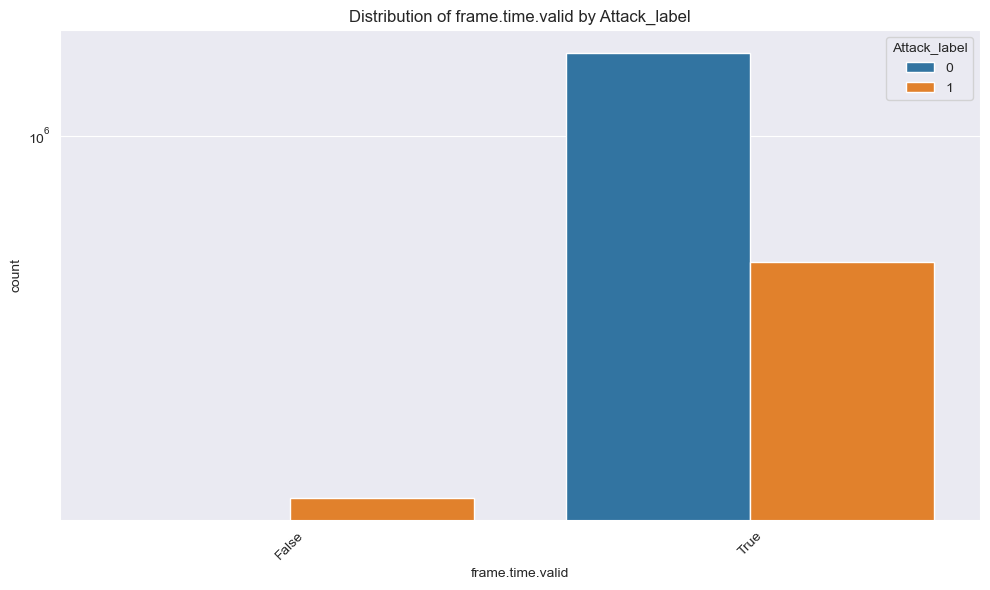

In [16]:
plot_target_relationship(df_main, "frame.time.valid", target_col="Attack_label", log_scale=True)

In [17]:
drop_string_columns("frame.time")

ALL columns left: 58
STRING columns left: 19


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""tcp.payload""",2219201,0,0.0,58.613,46.789,"""String""",274925,"""Categorical - High Cardinality"""
"""tcp.options""",2219201,0,0.0,65.518,51.439,"""String""",242565,"""Categorical - High Cardinality"""
"""ip.src_host""",2219201,0,0.0,43.355,13.286,"""String""",137167,"""Categorical - High Cardinality"""
"""tcp.srcport""",2219201,0,0.0,29.944,21.398,"""String""",61975,"""Categorical - High Cardinality"""
"""ip.dst_host""",2219201,0,0.0,43.195,13.214,"""String""",52425,"""Categorical - High Cardinality"""


Let's try encoding this

In [18]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
values = df_main["frame.time.valid"].to_numpy().reshape(-1, 1)
encoder.fit_transform(values).min()

0.0

In [19]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
values = df_main["frame.time.valid"].to_numpy().reshape(-1, 1)
values = encoder.fit_transform(values)
values.min(), values.max(), values.shape, encoder.categories_, len(encoder.categories_[0])

(0.0, 1.0, (2219201, 2), [array([False,  True])], 2)

#### Column `tcp.payload`: REMOVE

In [20]:
df_main["tcp.payload"].unique().head(n=5)

tcp.payload
str
"""000e1d3b2aa6c72a43722766a2c3f3…"
"""474554202f445657412f66696c6573…"
"""72781ec3eb94ac2daa386f673217c0…"
"""000e61aa38cc11334d0d4c32bfd706…"
"""485454502f312e312033303220466f…"


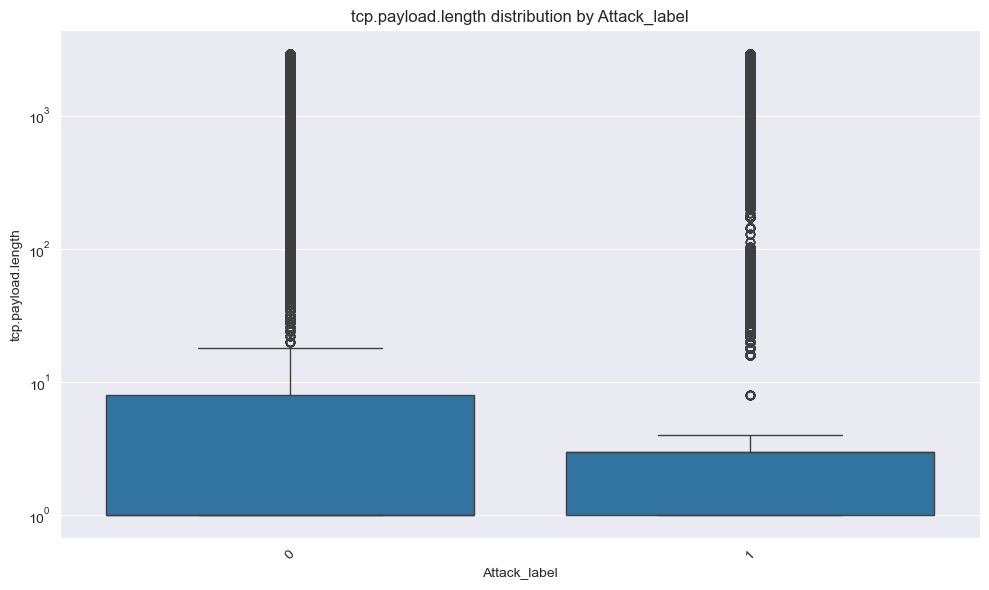

In [21]:
plot_target_relationship(
    df_main.with_columns(pl.col("tcp.payload").str.len_chars().alias("tcp.payload.length")),
    "tcp.payload.length",
    target_col="Attack_label",
    log_scale=True,
)

Seems there's no correlation between `tcp.payload.length` and `Attack_label`, we don't add it. Also since `tcp.payload` can be very arbitrary, for simplicity, we're gonna drop it.

In [22]:
drop_string_columns("tcp.payload")

ALL columns left: 57
STRING columns left: 18


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""tcp.options""",2219201,0,0.0,65.518,51.439,"""String""",242565,"""Categorical - High Cardinality"""
"""ip.src_host""",2219201,0,0.0,43.355,13.286,"""String""",137167,"""Categorical - High Cardinality"""
"""tcp.srcport""",2219201,0,0.0,29.944,21.398,"""String""",61975,"""Categorical - High Cardinality"""
"""ip.dst_host""",2219201,0,0.0,43.195,13.214,"""String""",52425,"""Categorical - High Cardinality"""
"""http.request.full_uri""",2219201,0,0.0,88.513,78.468,"""String""",11408,"""Categorical - High Cardinality"""


#### Column `tcp.options`: NUMERICAL

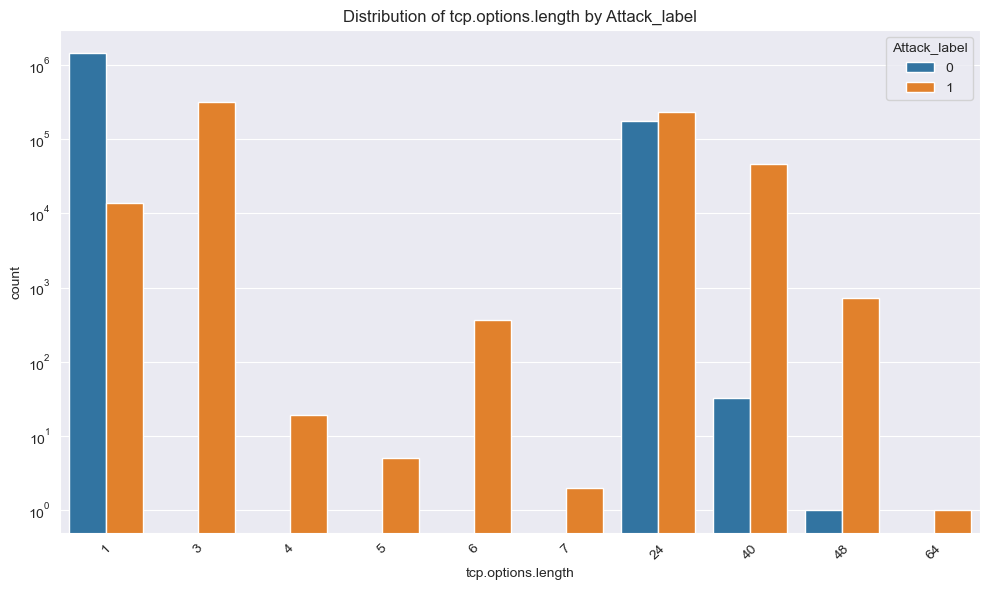

In [23]:
plot_target_relationship(
    df_main.with_columns(pl.col("tcp.options").str.len_chars().alias("tcp.options.length")),
    "tcp.options.length",
    target_col="Attack_label",
    log_scale=True,
)

We keep the length information. Seems it plays a role in determine `Attack_label` in some cases. We'd drop the `tcp.options` though.


In [24]:
df_main = df_main.with_columns(pl.col("tcp.options").str.len_chars().alias("tcp.options.length"))

In [25]:
drop_string_columns("tcp.options")

ALL columns left: 56
STRING columns left: 17


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""ip.src_host""",2219201,0,0.0,43.355,13.286,"""String""",137167,"""Categorical - High Cardinality"""
"""tcp.srcport""",2219201,0,0.0,29.944,21.398,"""String""",61975,"""Categorical - High Cardinality"""
"""ip.dst_host""",2219201,0,0.0,43.195,13.214,"""String""",52425,"""Categorical - High Cardinality"""
"""http.request.full_uri""",2219201,0,0.0,88.513,78.468,"""String""",11408,"""Categorical - High Cardinality"""
"""http.request.uri.query""",2219201,0,0.0,95.435,91.504,"""String""",5526,"""Categorical - High Cardinality"""


In [26]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
values = df_main["tcp.options.length"].to_numpy().reshape(-1, 1)
values = encoder.fit_transform(values)
values.min(), values.max(), np.unique(values)

(0.0, 9.0, array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

#### Columns `ip.src_host` and `ip.dst_host`: CATEGORIZE

In [27]:
df_main.filter(pl.col("Attack_label") == 0)["ip.src_host", "ip.dst_host"].head()

ip.src_host,ip.dst_host
str,str
"""192.168.0.128""","""192.168.0.101"""
"""192.168.0.101""","""192.168.0.128"""
"""192.168.0.128""","""192.168.0.101"""
"""192.168.0.128""","""192.168.0.101"""
"""192.168.0.101""","""192.168.0.128"""


In [28]:
import socket
import struct
import ipaddress


def ip_to_int(ip):
    try:
        return struct.unpack("!I", socket.inet_aton(ip))[0]
    except (OSError, socket.error):
        return None


def int_to_ip(i):
    return socket.inet_ntoa(struct.pack("!I", i))


def get_shared_subnet_mask(ip1, ip2, default_value="null"):
    try:
        ipaddress.IPv4Address(ip1)
        ipaddress.IPv4Address(ip2)
    except ipaddress.AddressValueError:
        return default_value

    ip1_int = ip_to_int(ip1)
    ip2_int = ip_to_int(ip2)

    if ip1_int is None or ip2_int is None:
        return default_value

    xor = ip1_int ^ ip2_int
    if xor == 0:
        mask_len = 32
    else:
        mask_len = 32 - xor.bit_length()

    mask_int = (0xFFFFFFFF << (32 - mask_len)) & 0xFFFFFFFF
    return int_to_ip(mask_int)

In [29]:
df_main = df_main.with_columns(
    pl.struct(["ip.src_host", "ip.dst_host"])
    .map_elements(
        lambda x: get_shared_subnet_mask(x["ip.src_host"], x["ip.dst_host"]), return_dtype=pl.Utf8
    )
    .alias("ip.subnet")
)

In [30]:
df_main["ip.subnet"].unique()

ip.subnet
str
"""240.0.0.0"""
"""255.252.0.0"""
"""255.255.255.255"""
"""255.248.0.0"""
"""255.224.0.0"""
…
"""255.240.0.0"""
"""255.255.255.0"""
"""255.254.0.0"""


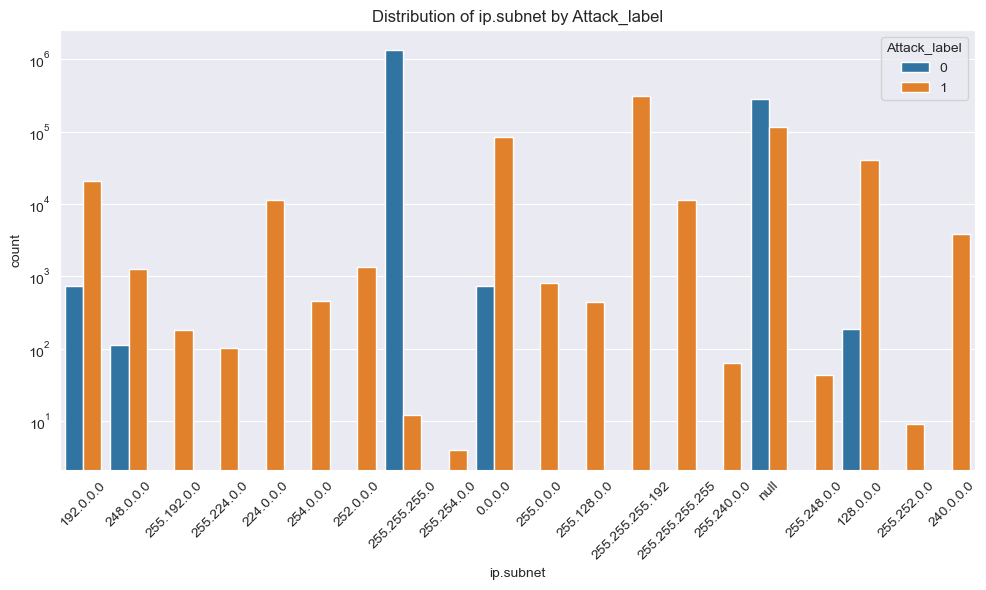

In [31]:
plot_target_relationship(
    df_main,
    "ip.subnet",
    target_col="Attack_label",
    log_scale=True,
)

In [32]:
drop_string_columns("ip.src_host", "ip.dst_host")

ALL columns left: 54
STRING columns left: 15


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""tcp.srcport""",2219201,0,0.0,29.944,21.398,"""String""",61975,"""Categorical - High Cardinality"""
"""http.request.full_uri""",2219201,0,0.0,88.513,78.468,"""String""",11408,"""Categorical - High Cardinality"""
"""http.request.uri.query""",2219201,0,0.0,95.435,91.504,"""String""",5526,"""Categorical - High Cardinality"""
"""http.file_data""",2219201,0,0.0,92.516,87.032,"""String""",2396,"""Categorical - High Cardinality"""
"""mqtt.msg""",2219201,0,0.0,69.062,41.865,"""String""",136,"""Categorical - High Cardinality"""


#### Column `tcp.srcport`: REMOVE

In [33]:
def try_convert_to_float(x, default_value=-1):
    try:
        num = float(x)
        return int(num) if num == int(num) else num
    except ValueError:
        return default_value

In [34]:
df_main = df_main.with_columns(
    pl.col("tcp.srcport")
    .map_elements(try_convert_to_float, return_dtype=pl.Float64)
    .alias("tcp.srcport.num")
)

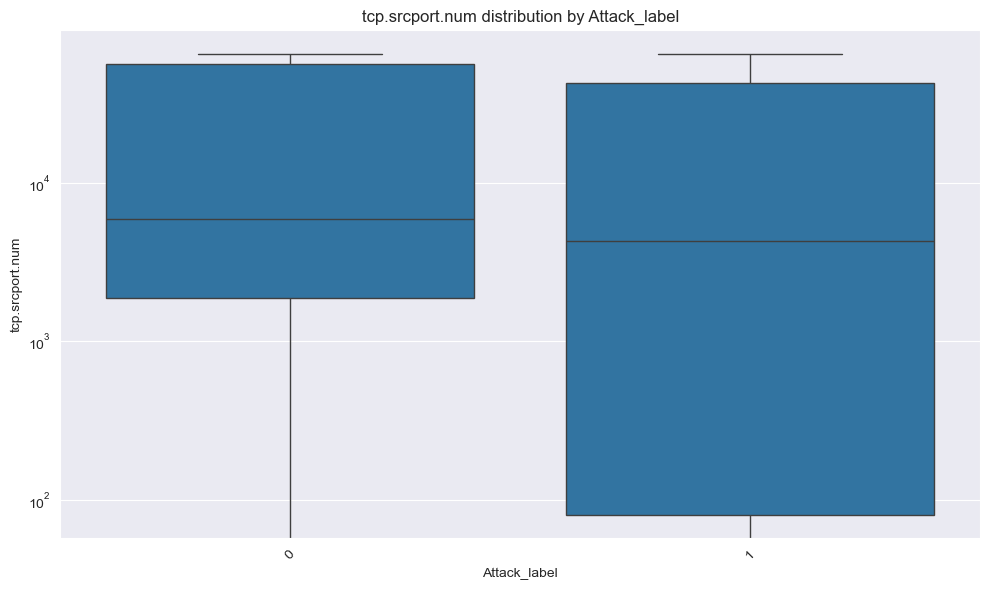

In [35]:
plot_target_relationship(
    df_main,
    "tcp.srcport.num",
    target_col="Attack_label",
    log_scale=True,
)

In [36]:
drop_string_columns("tcp.srcport")

ALL columns left: 53
STRING columns left: 14


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""http.request.full_uri""",2219201,0,0.0,88.513,78.468,"""String""",11408,"""Categorical - High Cardinality"""
"""http.request.uri.query""",2219201,0,0.0,95.435,91.504,"""String""",5526,"""Categorical - High Cardinality"""
"""http.file_data""",2219201,0,0.0,92.516,87.032,"""String""",2396,"""Categorical - High Cardinality"""
"""mqtt.msg""",2219201,0,0.0,69.062,41.865,"""String""",136,"""Categorical - High Cardinality"""
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""


#### Column `http.request.full_uri`: REMOVE

In [37]:
df_main = df_main.with_columns(
    pl.col("http.request.full_uri").str.len_chars().alias("http.request.full_uri.length")
)
df_main["http.request.full_uri.length"].describe()

statistic,value
str,f64
"""count""",2.219201e6
"""null_count""",0.0
"""mean""",3.966321
"""std""",14.132523
"""min""",1.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",4166.0


In [38]:
df_main.filter(pl.col("Attack_label") == 0)["http.request.full_uri.length"].describe()

statistic,value
str,f64
"""count""",1.615643e6
"""null_count""",0.0
"""mean""",3.0
"""std""",0.0
"""min""",3.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",3.0


In [39]:
df_main.filter(pl.col("Attack_label") == 1)["http.request.full_uri.length"].describe()

statistic,value
str,f64
"""count""",603558.0
"""null_count""",0.0
"""mean""",6.553031
"""std""",26.929237
"""min""",1.0
"""25%""",1.0
"""50%""",3.0
"""75%""",3.0
"""max""",4166.0


In [40]:
drop_string_columns("http.request.full_uri")

ALL columns left: 52
STRING columns left: 13


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""http.request.uri.query""",2219201,0,0.0,95.435,91.504,"""String""",5526,"""Categorical - High Cardinality"""
"""http.file_data""",2219201,0,0.0,92.516,87.032,"""String""",2396,"""Categorical - High Cardinality"""
"""mqtt.msg""",2219201,0,0.0,69.062,41.865,"""String""",136,"""Categorical - High Cardinality"""
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.conack.flags""",2219201,0,0.0,69.06,41.863,"""String""",13,"""Categorical - High Cardinality"""


#### Column `http.request.uri.query`: REMOVE

In [41]:
df_main["http.request.uri.query"].unique().head(n=5)

http.request.uri.query
str
"""categoriesenabled=yes&do=categ…"
"""/c+dir+c:\+/OG"""
"""w=1&h=1&s=1&min=1&max=2&f[]=x.…"
"""CssFile=http://cirt.net/rfiinc…"
"""id=2&Submit=Submitid%3D53%27%2…"


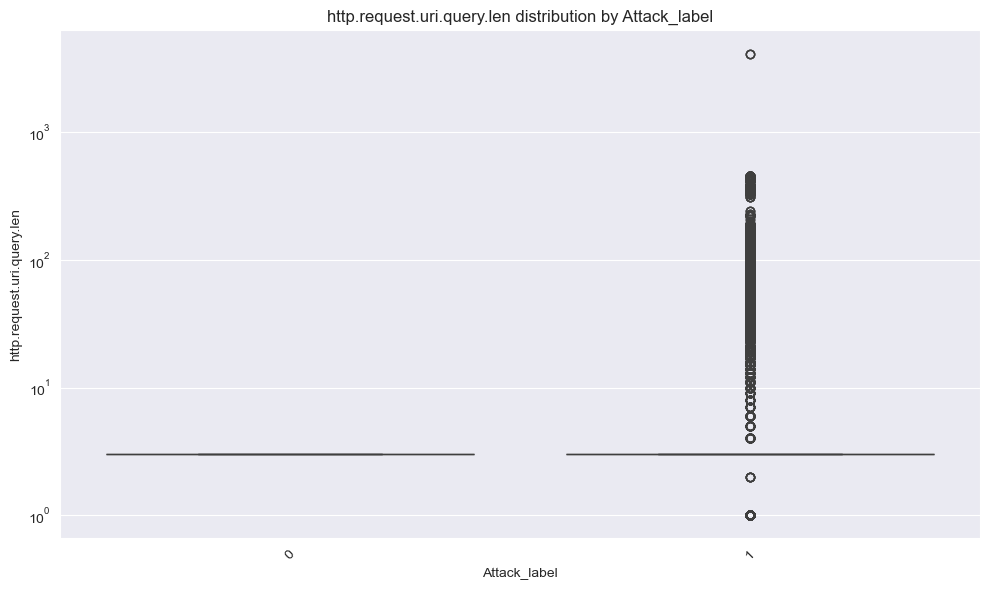

In [42]:
plot_target_relationship(
    df_main.with_columns(
        pl.col("http.request.uri.query").str.len_chars().alias("http.request.uri.query.len")
    ),
    "http.request.uri.query.len",
    target_col="Attack_label",
    log_scale=True,
)

In [43]:
df_main.filter(pl.col("Attack_label") == 0).with_columns(
    pl.col("http.request.uri.query").str.len_chars().alias("http.request.uri.query.len")
)["http.request.uri.query.len"].describe()

statistic,value
str,f64
"""count""",1.615643e6
"""null_count""",0.0
"""mean""",3.0
"""std""",0.0
"""min""",3.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",3.0


In [44]:
df_main.filter(pl.col("Attack_label") == 1).with_columns(
    pl.col("http.request.uri.query").str.len_chars().alias("http.request.uri.query.len")
)["http.request.uri.query.len"].describe()

statistic,value
str,f64
"""count""",603558.0
"""null_count""",0.0
"""mean""",4.548189
"""std""",20.281509
"""min""",1.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",4128.0


Almost similar, can remove the column

In [45]:
drop_string_columns("http.request.uri.query")

ALL columns left: 51
STRING columns left: 12


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""http.file_data""",2219201,0,0.0,92.516,87.032,"""String""",2396,"""Categorical - High Cardinality"""
"""mqtt.msg""",2219201,0,0.0,69.062,41.865,"""String""",136,"""Categorical - High Cardinality"""
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.conack.flags""",2219201,0,0.0,69.06,41.863,"""String""",13,"""Categorical - High Cardinality"""
"""http.request.version""",2219201,0,0.0,88.458,78.362,"""String""",13,"""Categorical - High Cardinality"""


####  Column `http.file_data`: REMOVE

In [46]:
df_main.filter(pl.col("Attack_label") == 0).with_columns(
    pl.col("http.file_data").str.len_chars().alias("http.file_data.length")
)["http.file_data.length"].describe()

statistic,value
str,f64
"""count""",1.615643e6
"""null_count""",0.0
"""mean""",3.0
"""std""",0.0
"""min""",3.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",3.0


In [47]:
df_main.filter(pl.col("Attack_label") == 1).with_columns(
    pl.col("http.file_data").str.len_chars().alias("http.file_data.length")
)["http.file_data.length"].describe()

statistic,value
str,f64
"""count""",603558.0
"""null_count""",0.0
"""mean""",20.909805
"""std""",115.022532
"""min""",1.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",1844.0


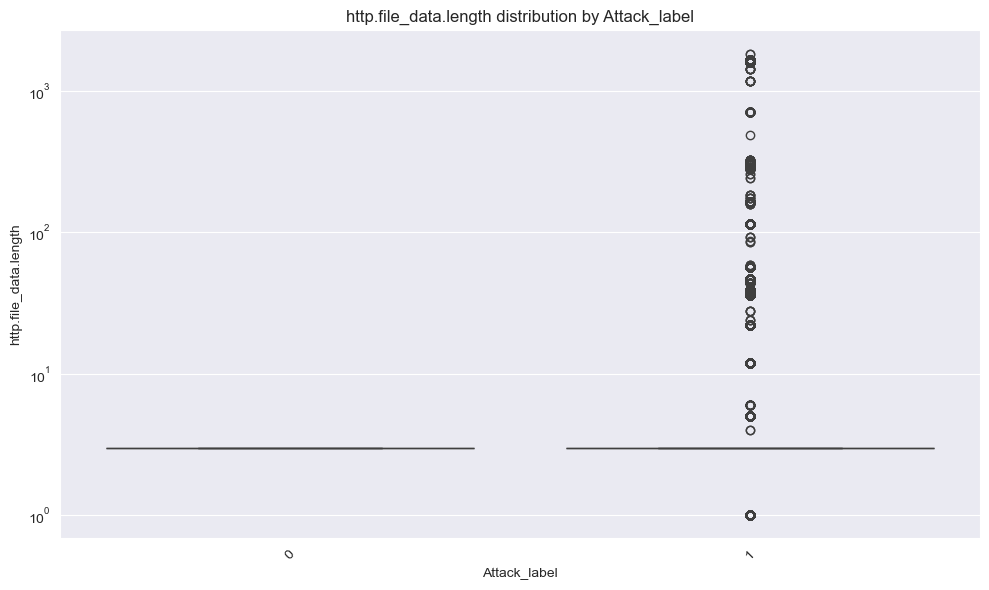

In [48]:
plot_target_relationship(
    df_main.with_columns(pl.col("http.file_data").str.len_chars().alias("http.file_data.length")),
    "http.file_data.length",
    target_col="Attack_label",
    log_scale=True,
)

Can ignore this field as 75% is similar.

In [49]:
drop_string_columns("http.file_data")

ALL columns left: 50
STRING columns left: 11


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""mqtt.msg""",2219201,0,0.0,69.062,41.865,"""String""",136,"""Categorical - High Cardinality"""
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.conack.flags""",2219201,0,0.0,69.06,41.863,"""String""",13,"""Categorical - High Cardinality"""
"""http.request.version""",2219201,0,0.0,88.458,78.362,"""String""",13,"""Categorical - High Cardinality"""
"""dns.qry.name.len""",2219201,0,0.0,72.72,45.533,"""String""",10,"""Categorical"""


#### Column `mqtt.msg`: USE LENGTH

In [50]:
df_main.filter(pl.col("Attack_label") == 0).with_columns(
    pl.col("mqtt.msg").str.len_chars().alias("mqtt.msg.len")
)["mqtt.msg.len"].describe()

statistic,value
str,f64
"""count""",1.615643e6
"""null_count""",0.0
"""mean""",2.284566
"""std""",5.519426
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",26.0


In [51]:
df_main.filter(pl.col("Attack_label") == 1).with_columns(
    pl.col("mqtt.msg").str.len_chars().alias("mqtt.msg.len")
)["mqtt.msg.len"].describe()

statistic,value
str,f64
"""count""",603558.0
"""null_count""",0.0
"""mean""",3.0
"""std""",0.0
"""min""",3.0
"""25%""",3.0
"""50%""",3.0
"""75%""",3.0
"""max""",3.0


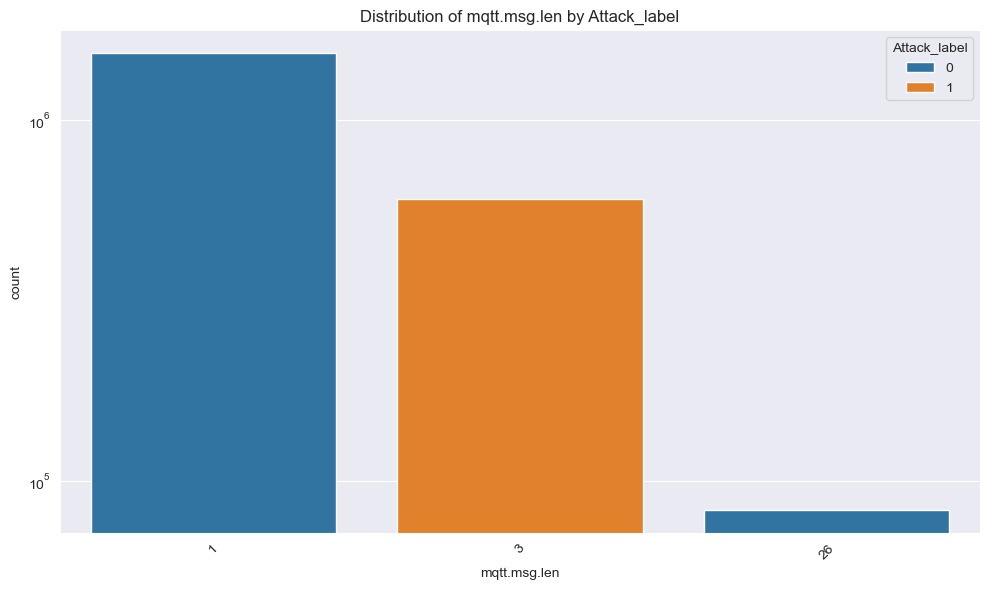

In [52]:
df_main = df_main.with_columns(pl.col("mqtt.msg").str.len_chars().alias("mqtt.msg.len"))
plot_target_relationship(
    df_main,
    "mqtt.msg.len",
    target_col="Attack_label",
    log_scale=True,
)

In [53]:
drop_string_columns("mqtt.msg")

ALL columns left: 49
STRING columns left: 10


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.conack.flags""",2219201,0,0.0,69.06,41.863,"""String""",13,"""Categorical - High Cardinality"""
"""http.request.version""",2219201,0,0.0,88.458,78.362,"""String""",13,"""Categorical - High Cardinality"""
"""dns.qry.name.len""",2219201,0,0.0,72.72,45.533,"""String""",10,"""Categorical"""
"""arp.src.proto_ipv4""",2219201,0,0.0,94.203,88.67,"""String""",10,"""Categorical"""


#### Column `http.request.version`: CATEGORIZE

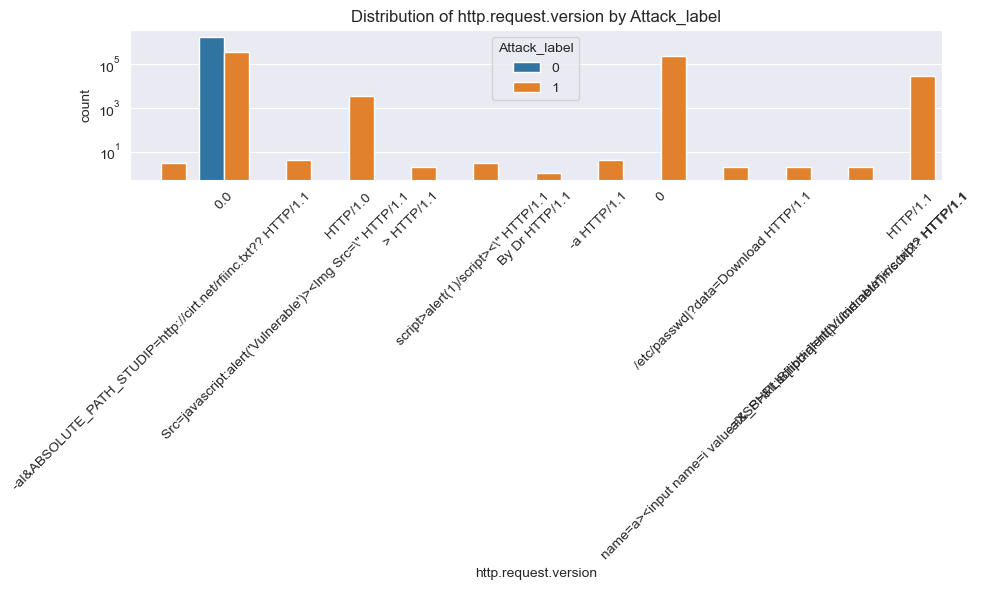

In [54]:
plot_target_relationship(
    df_main,
    "http.request.version",
    target_col="Attack_label",
    log_scale=True,
)

In [55]:
drop_string_columns("http.request.version")

ALL columns left: 48
STRING columns left: 9


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.conack.flags""",2219201,0,0.0,69.06,41.863,"""String""",13,"""Categorical - High Cardinality"""
"""dns.qry.name.len""",2219201,0,0.0,72.72,45.533,"""String""",10,"""Categorical"""
"""arp.src.proto_ipv4""",2219201,0,0.0,94.203,88.67,"""String""",10,"""Categorical"""
"""arp.dst.proto_ipv4""",2219201,0,0.0,99.162,98.574,"""String""",9,"""Categorical"""


#### Column `mqtt.conack.flags`: CATEGORIZE

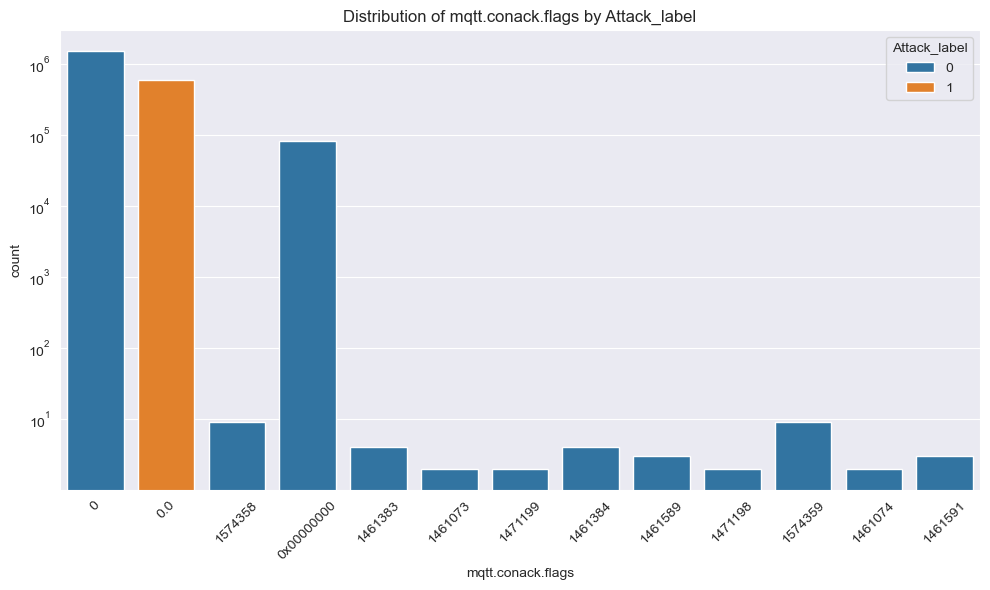

In [56]:
plot_target_relationship(
    df_main,
    "mqtt.conack.flags",
    target_col="Attack_label",
    log_scale=True,
)

In [57]:
drop_string_columns("mqtt.conack.flags")

ALL columns left: 47
STRING columns left: 8


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""dns.qry.name.len""",2219201,0,0.0,72.72,45.533,"""String""",10,"""Categorical"""
"""arp.src.proto_ipv4""",2219201,0,0.0,94.203,88.67,"""String""",10,"""Categorical"""
"""arp.dst.proto_ipv4""",2219201,0,0.0,99.162,98.574,"""String""",9,"""Categorical"""
"""http.request.method""",2219201,0,0.0,88.513,78.472,"""String""",9,"""Categorical"""


#### Columns `arp.src.proto_ipv4` and `arp.dst.proto_ipv4`: REMOVE BOTH

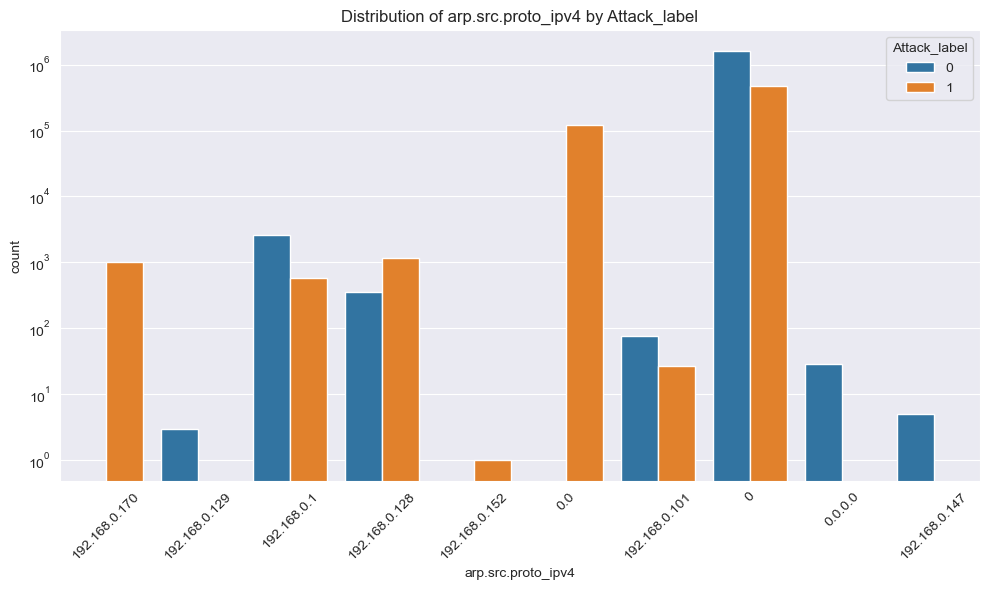

In [58]:
plot_target_relationship(
    df_main,
    "arp.src.proto_ipv4",
    target_col="Attack_label",
    log_scale=True,
)

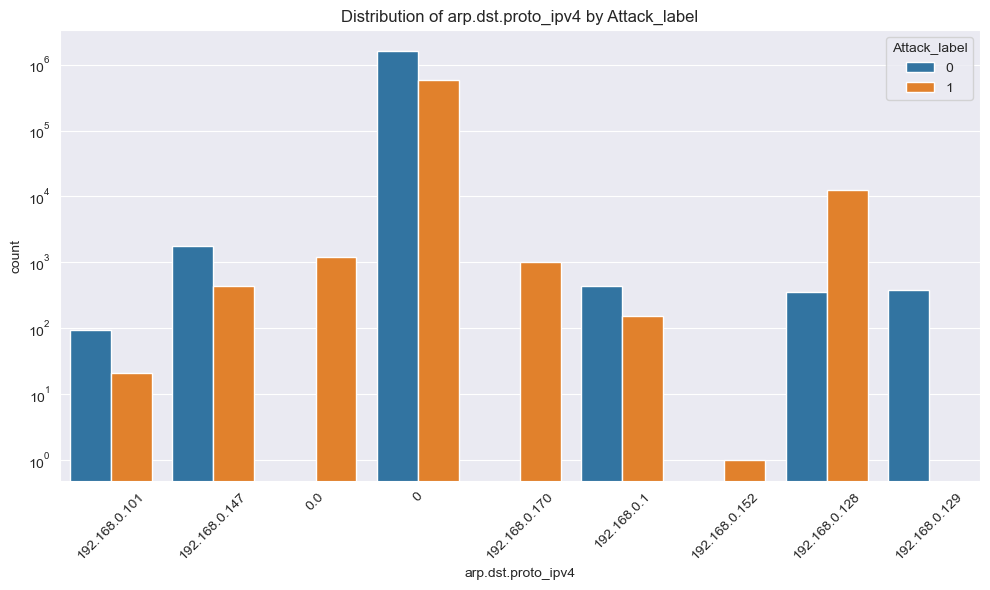

In [59]:
plot_target_relationship(
    df_main,
    "arp.dst.proto_ipv4",
    target_col="Attack_label",
    log_scale=True,
)

In [60]:
df_main = df_main.with_columns(
    pl.struct(["arp.src.proto_ipv4", "arp.dst.proto_ipv4"])
    .map_elements(
        lambda x: get_shared_subnet_mask(x["arp.src.proto_ipv4"], x["arp.dst.proto_ipv4"]),
        return_dtype=pl.Utf8,
    )
    .alias("arp.subnet.proto_ipv4")
)

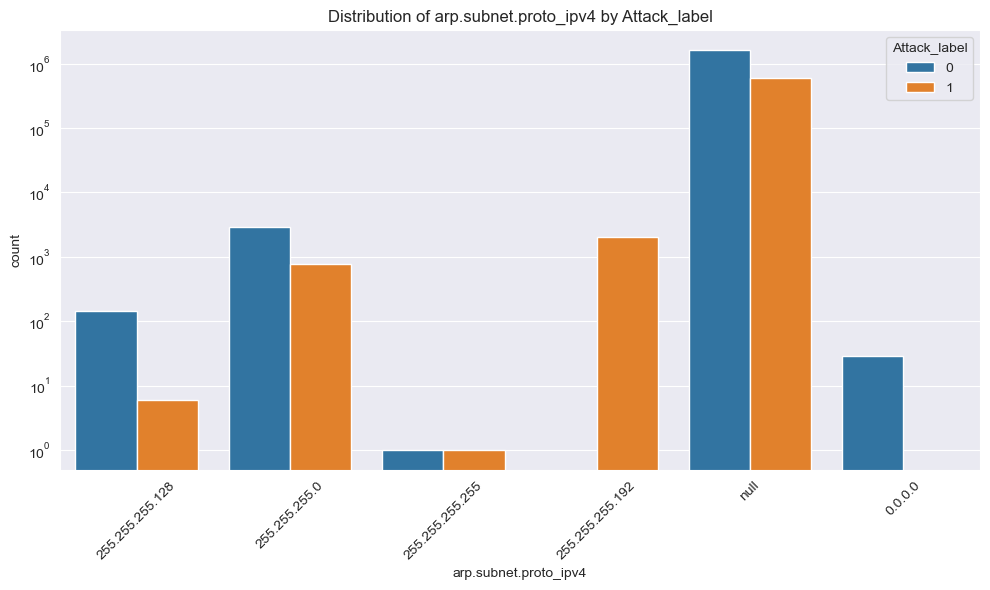

In [61]:
plot_target_relationship(
    df_main,
    "arp.subnet.proto_ipv4",
    target_col="Attack_label",
    log_scale=True,
)

In [62]:
drop_string_columns("arp.src.proto_ipv4", "arp.dst.proto_ipv4")

ALL columns left: 45
STRING columns left: 6


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""dns.qry.name.len""",2219201,0,0.0,72.72,45.533,"""String""",10,"""Categorical"""
"""http.request.method""",2219201,0,0.0,88.513,78.472,"""String""",9,"""Categorical"""
"""http.referer""",2219201,0,0.0,94.776,89.577,"""String""",5,"""Categorical"""
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""


#### Column `http.request.method`: CATEGORIZE

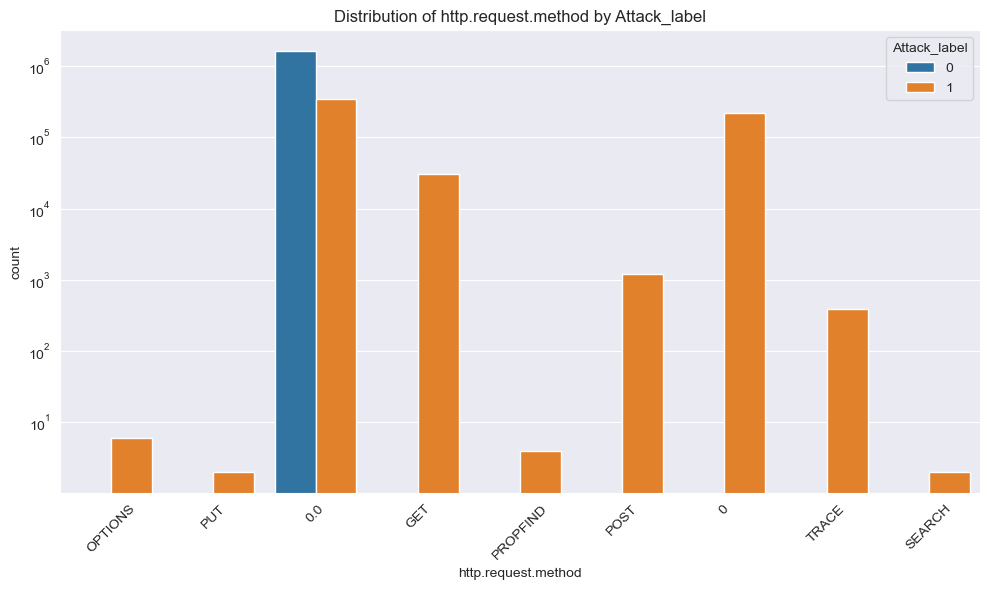

In [63]:
plot_target_relationship(
    df_main,
    "http.request.method",
    target_col="Attack_label",
    log_scale=True,
)

In [64]:
drop_string_columns("http.request.method")

ALL columns left: 44
STRING columns left: 5


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""dns.qry.name.len""",2219201,0,0.0,72.72,45.533,"""String""",10,"""Categorical"""
"""http.referer""",2219201,0,0.0,94.776,89.577,"""String""",5,"""Categorical"""
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""
"""mqtt.protoname""",2219201,0,0.0,69.061,41.864,"""String""",3,"""Categorical"""


#### Column `dns.qry.name.len`: CATEGORIZE

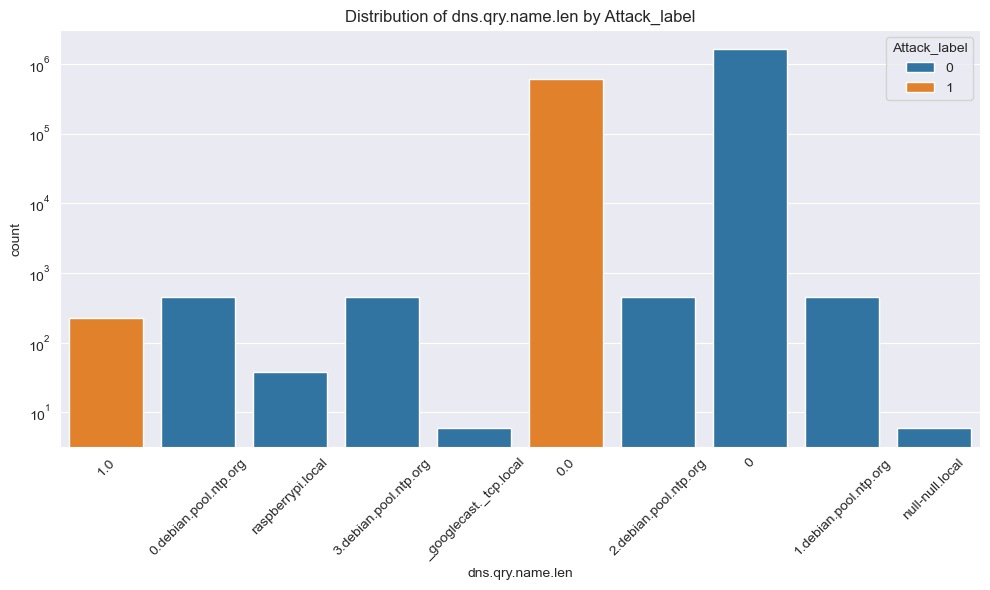

In [65]:
plot_target_relationship(
    df_main,
    "dns.qry.name.len",
    target_col="Attack_label",
    log_scale=True,
)

In [66]:
drop_string_columns("dns.qry.name.len")

ALL columns left: 43
STRING columns left: 4


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""http.referer""",2219201,0,0.0,94.776,89.577,"""String""",5,"""Categorical"""
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""
"""mqtt.protoname""",2219201,0,0.0,69.061,41.864,"""String""",3,"""Categorical"""


#### Column `http.referer`: CATEGORIZE

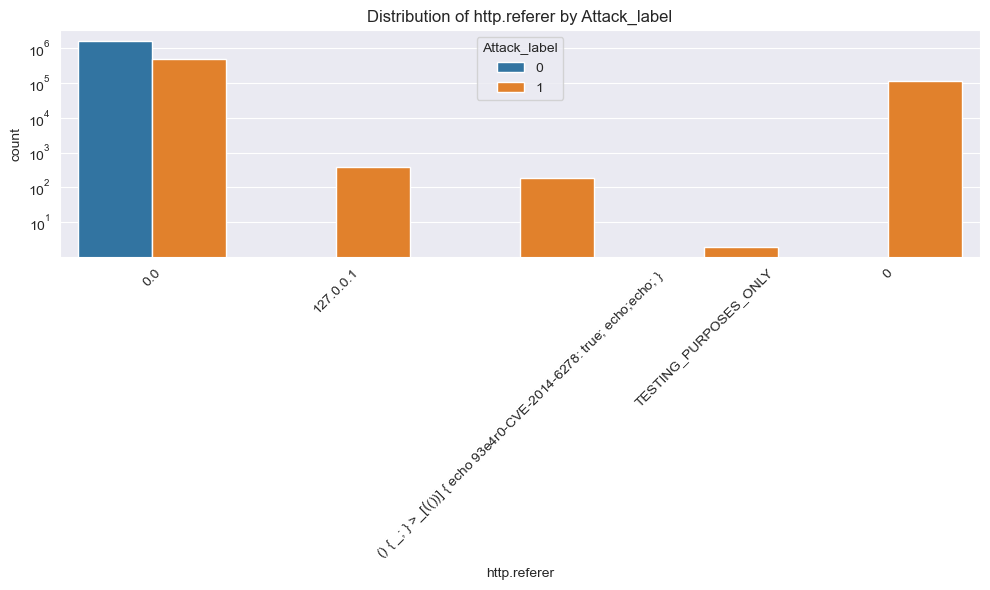

In [67]:
plot_target_relationship(
    df_main,
    "http.referer",
    target_col="Attack_label",
    log_scale=True,
)

We can keep this one.

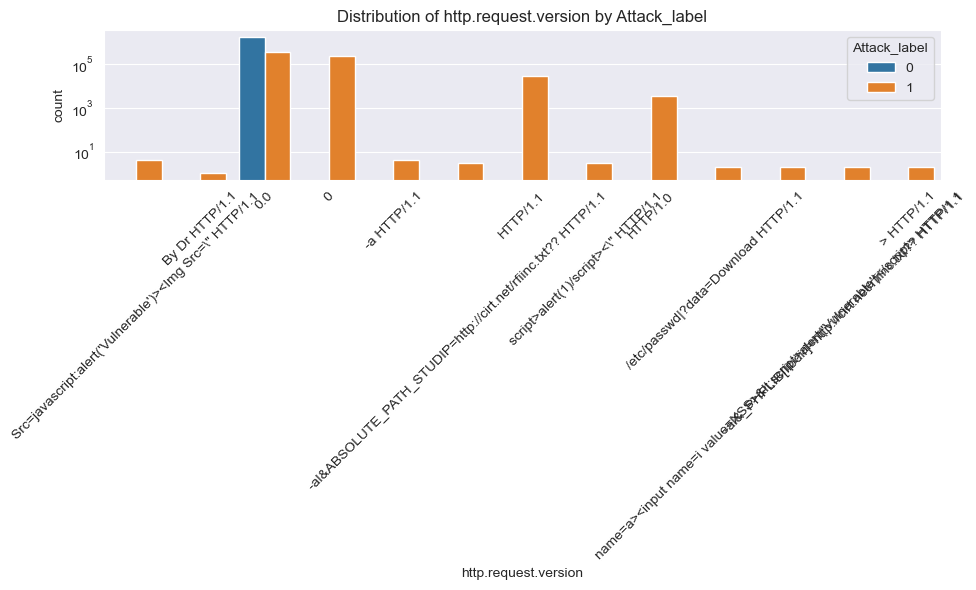

In [68]:
plot_target_relationship(
    df_main,
    "http.request.version",
    target_col="Attack_label",
    log_scale=True,
)

In [69]:
drop_string_columns("http.referer")

ALL columns left: 42
STRING columns left: 3


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""
"""mqtt.protoname""",2219201,0,0.0,69.061,41.864,"""String""",3,"""Categorical"""


#### Column `mqtt.protoname`: CATEGORIZE

In [70]:
df_main["mqtt.protoname"].unique()

mqtt.protoname
str
"""MQTT"""
"""0"""
"""0.0"""


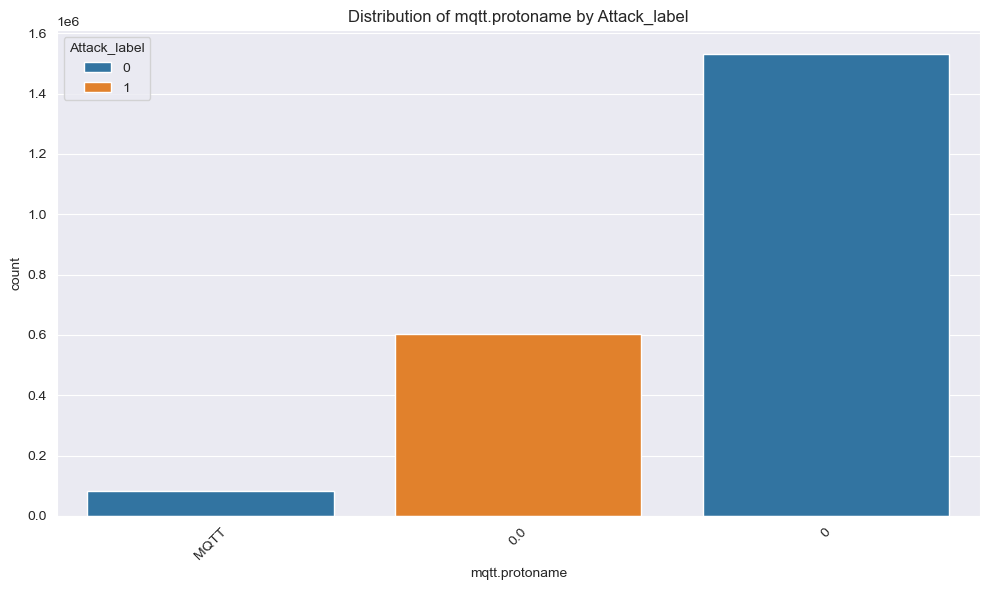

In [71]:
plot_target_relationship(df_main, "mqtt.protoname", target_col="Attack_label")

Seems its relevant to anomaly detection. We'd keep it as it is (categorical data).

In [72]:
drop_string_columns("mqtt.protoname")

ALL columns left: 41
STRING columns left: 2


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""


#### Remaining String columns if any will be categorized

In [73]:
string_columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Attack_type""",2219201,0,0.0,72.803,67.325,"""String""",15,"""Categorical - High Cardinality"""
"""mqtt.topic""",2219201,0,0.0,69.062,41.865,"""String""",3,"""Categorical"""


### Numerical Columns

In [74]:
numerical_columns_df = columns_df.filter(pl.col("Variable type") != "String").sort(
    by="Unique values", descending=True
)
numerical_columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""tcp.ack_raw""",2219201,0,0.0,24.38,24.097,"""Float64""",915938,"""Categorical - High Cardinality"""
"""tcp.seq""",2219201,0,0.0,23.148,2.579,"""Float64""",213310,"""Categorical - High Cardinality"""
"""tcp.ack""",2219201,0,0.0,24.38,8.925,"""Float64""",146980,"""Categorical - High Cardinality"""
"""udp.stream""",2219201,0,0.0,94.422,94.372,"""Float64""",120450,"""Categorical - High Cardinality"""
"""tcp.checksum""",2219201,0,0.0,11.578,11.575,"""Float64""",65536,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""mqtt.topic_len""",2219201,0,0.0,96.259,92.518,"""Float64""",2,"""Flag"""
"""mqtt.ver""",2219201,0,0.0,96.258,92.516,"""Float64""",2,"""Flag"""
"""arp.hw.size""",2219201,0,0.0,99.736,99.472,"""Float64""",2,"""Flag"""
